In [1]:
!pip install genaibook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
from genaibook.core import get_device
device = get_device()

In [3]:
import requests
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

from genaibook.core import SampleURL

clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

url = SampleURL.LionExample
image = Image.open(requests.get(url, stream=True).raw)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:
image_inputs = processor(images=image, return_tensors="pt")
pixel_values = image_inputs["pixel_values"]
pixel_values.shape, pixel_values.min(), pixel_values.max()

(torch.Size([1, 3, 224, 224]), tensor(-1.7923), tensor(1.9895))

In [5]:
processor.image_processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

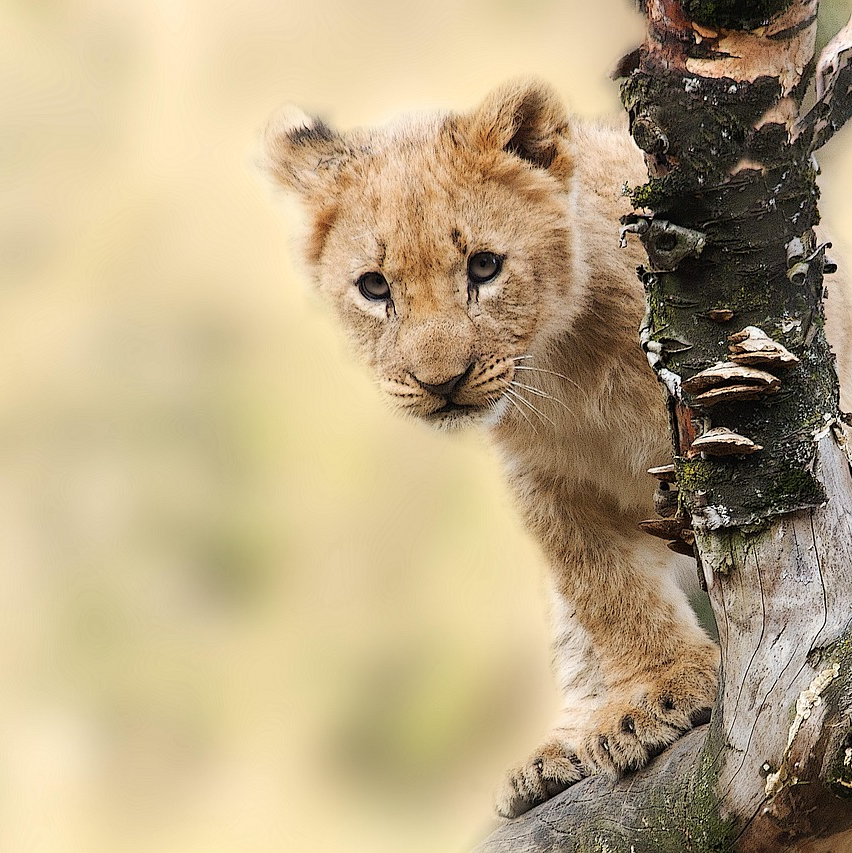

In [6]:
width, height = image.size
crop_length = min(image.size)

left = (width - crop_length) / 2
top = (height - crop_length) / 2
right = (width + crop_length) / 2
bottom = (height + crop_length) / 2

cropped = image.crop((left, top, right, bottom))
cropped

In [9]:
import torch

In [10]:
with torch.inference_mode():
    output = clip.vision_model(pixel_values.to(device))
image_embeddings = output.pooler_output
image_embeddings.shape

torch.Size([1, 1024])

In [11]:
prompts = [
    "a photo of a lion",
    "a photo of a zebra",
]

# Padding makes sure all inputs have the same length
text_inputs = processor(text=prompts, return_tensors="pt", padding=True)
text_inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  5567, 49407],
        [49406,   320,  1125,   539,   320, 22548, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}

In [12]:
text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

with torch.inference_mode():
    text_output = clip.text_model(**text_inputs)

In [13]:
text_embeddings = text_output.pooler_output
text_embeddings.shape

torch.Size([2, 768])

In [14]:
print(clip.text_projection)
print(clip.visual_projection)

Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=1024, out_features=768, bias=False)


In [15]:
with torch.inference_mode():
    text_embeddings = clip.text_projection(text_embeddings)
    image_embeddings = clip.visual_projection(image_embeddings)
text_embeddings.shape, image_embeddings.shape

(torch.Size([2, 768]), torch.Size([1, 768]))

In [16]:
text_embeddings = text_embeddings / text_embeddings.norm(
    p=2, dim=-1, keepdim=True
)
image_embeddings = image_embeddings / image_embeddings.norm(
    p=2, dim=-1, keepdim=True
)

In [17]:
similarities = torch.matmul(text_embeddings, image_embeddings.T)
similarities

tensor([[0.2226],
        [0.1936]])

In [18]:
similarities = 100 * torch.matmul(text_embeddings, image_embeddings.T)
similarities.softmax(dim=0).cpu()

tensor([[0.9479],
        [0.0521]])

**Zero-Shot Image Classification with CLIP**

In [19]:
clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
image = Image.open(requests.get(SampleURL.LionExample, stream=True).raw)

In [20]:
prompts = [
    "a photo of a lion",
    "a photo of a zebra",
    "a photo of a cat",
    "a photo of an adorable lion cub",
    "a puppy",
    "a lion behind a branch",
]
inputs = processor(
    text=prompts, images=image, return_tensors="pt", padding=True
)
inputs = {k: v.to(device) for k, v in inputs.items()}

outputs = clip(**inputs)
logits_per_image = outputs.logits_per_image
probabilities = logits_per_image.softmax(dim=1)

In [21]:

probabilities = probabilities[0].cpu().detach().tolist()

In [22]:
for prob, prompt in sorted(zip(probabilities, prompts), reverse=True):
    print(f"{100*prob: =2.0f}%: {prompt}")

84%: a photo of an adorable lion cub
13%: a lion behind a branch
 3%: a photo of a lion
 0%: a photo of a zebra
 0%: a photo of a cat
 0%: a puppy


In [23]:
from transformers import pipeline

classifier = pipeline(
    "zero-shot-image-classification",
    model="openai/clip-vit-large-patch14",
    device=device,
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [24]:
scores = classifier(
    image,
    candidate_labels=prompts,
    hypothesis_template="{}",
)

In [25]:
print(scores)

[{'score': 0.8392914533615112, 'label': 'a photo of an adorable lion cub'}, {'score': 0.12917999923229218, 'label': 'a lion behind a branch'}, {'score': 0.029191995039582253, 'label': 'a photo of a lion'}, {'score': 0.0016057725297287107, 'label': 'a photo of a zebra'}, {'score': 0.0007013280992396176, 'label': 'a photo of a cat'}, {'score': 2.9521015676436946e-05, 'label': 'a puppy'}]
